In [1]:
'''@author: Zi Xian Leong (zxleong@psu.edu) '''

import numpy as np
import matplotlib.pyplot as plt
from random import uniform as rand
import scipy.io as sio
import os
from sklearn.model_selection import train_test_split
from skimage.transform import rescale, resize
from sklearn.metrics import accuracy_score
from sklearn import preprocessing as pp

from numpy.matlib import repmat

from sklearn.metrics import r2_score, mean_squared_error
import pandas as pd
import scipy.ndimage.filters as fil
from keras import backend as K
from matplotlib.ticker import FormatStrFormatter
from scipy.signal import savgol_filter

from tqdm import tqdm
import scipy.stats
from scipy.signal import tukey
import sys

from DLcodes.GPRNet import GPRNet
import seaborn as sns
import string
import matplotlib



Using TensorFlow backend.


In [3]:
#Load data set used for field prediction

X_test = np.load('Field/Data/ForDL/field_X_test.npy')
y_true = np.load('Field/Data/ForDL/field_y_true.npy')
FieldData = np.load('Field/Data/pcsfielddata/ProcessedFieldData.npy')

print(X_test.shape)
print(y_true.shape)
print(FieldData.shape)

(12500, 400, 1)
(12500, 400, 1)
(208, 400)


### We need to compare predictions of vanilla (original unique) vs altered (added noise and time gain) versions.
### Follow steps 12 - 15 to create a new unseen testing data set that includes added noise and time gain. I created 250 new data set
### I call the new unseen data set as spec_xtest



In [4]:
spec_xtest = np.load('UQ/Data/Field/X_test_spec.npy')
spec_xtest_norm = pp.normalize(spec_xtest,norm='max',axis=1)
spec_ytrue = np.load('UQ/Data/Field/y_True_spec.npy')

#Predict spec data set WITHOUT using dropout
base_path = 'Field/Weights/'
model_name = 'weight_GPRNet_n32k10.h5' 
cnn_model = GPRNet(im_width=1, im_height=400, neurons=32, kern_sz = 10,enable_dropout=False)
cnn_model.load_weights(base_path+model_name)

spec_ypred = np.squeeze(cnn_model.predict(np.expand_dims(spec_xtest_norm,axis=2)),axis=2)
print(spec_ypred.shape)
#save
#np.save('UQ/Data/Field/ypred_spec.npy',spec_ypred)

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
spec_ypred = np.load('UQ/Data/Field/ypred_spec.npy')

In [8]:
#Arrange the xtest, ytrue, and ypred in a way that can be accessed easily

#1 to #10 - original unique
#11 - #90 - Only Noise added
#91 - #170 - Only Time Gain added
#171 - #250 - Noise and Time Gain added

#corresponding profiles/traces:
# #1 --> #11_noise1, #21_noise2, etc
# #2 --> #12_noise1, #22_noise2, etc

spec_xtest_dict = dict()
spec_ytrue_dict = dict()
spec_ypred_dict = dict()

length_unique = 10
for i in range(10):
    spec_xtest_dict['ind{}'.format(i)] = spec_xtest_norm[i,:] # original data
    spec_ytrue_dict['ind{}'.format(i)] = spec_ytrue[i,:] # original vel
    spec_ypred_dict['ind{}'.format(i)] = spec_ypred[i,:] # prediction vel
    
    all_ind_n = np.arange(i+length_unique,80+length_unique,length_unique)
    all_ind_tg = np.arange(i+length_unique+80,160+length_unique,length_unique)
    all_ind_ntg = np.arange(i+length_unique+160,240+length_unique,length_unique)

    spec_xtest_dict['ind{}_n'.format(i)] = spec_xtest_norm[all_ind_n,:] #noise only
    spec_ytrue_dict['ind{}_n'.format(i)] = spec_ytrue[all_ind_n,:] 
    spec_ypred_dict['ind{}_n'.format(i)] = spec_ypred[all_ind_n,:] 

    spec_xtest_dict['ind{}_tg'.format(i)] = spec_xtest_norm[all_ind_tg,:] #time gain only
    spec_ytrue_dict['ind{}_tg'.format(i)] = spec_ytrue[all_ind_tg,:] 
    spec_ypred_dict['ind{}_tg'.format(i)] = spec_ypred[all_ind_tg,:] 

    spec_xtest_dict['ind{}_ntg'.format(i)] = spec_xtest_norm[all_ind_ntg,:] #noise on time gain
    spec_ytrue_dict['ind{}_ntg'.format(i)] = spec_ytrue[all_ind_ntg,:] 
    spec_ypred_dict['ind{}_ntg'.format(i)] = spec_ypred[all_ind_ntg,:] 




## Compare vanilla vs altered - Figure 15

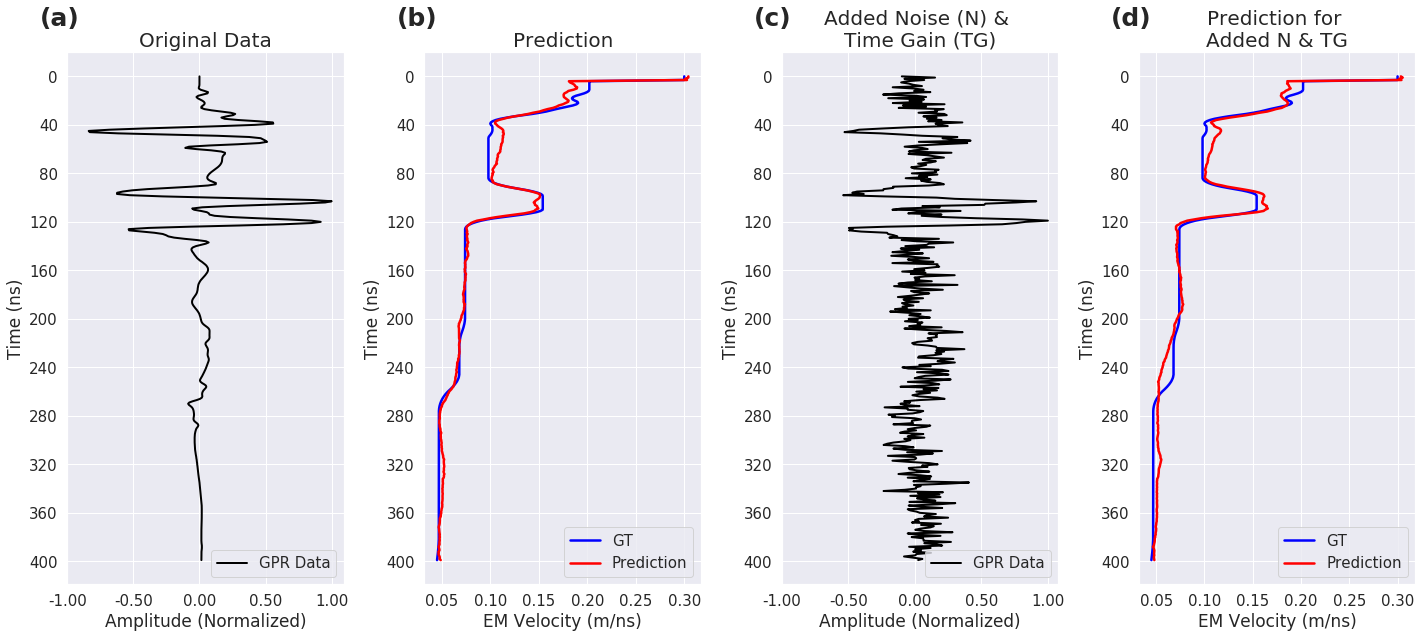

In [10]:
sns.set_theme(style='darkgrid')
def figure15():
    # ind = np.random.randint(10) 
    ind=4
    # print(ind) #4
    fig,axs =plt.subplots(1,4,figsize=(20,9))
    sns.set_theme(style='darkgrid')
    ax = axs[0]
    ax.invert_yaxis()
    x = np.arange(400)
    ax.plot(spec_xtest_dict['ind{}'.format(ind)],x,label='GPR Data', color='black', linewidth=2)
    ax.set_xlabel('Amplitude (Normalized)', fontsize=17)
    ax.set_ylabel('Time (ns)', fontsize=17)
    ax.set_xticks(np.arange(-1,1.5,0.5))
    ax.set_xticklabels(np.arange(-1,1.5,0.5),fontsize=15)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.set_yticks(np.arange(0,440,40))
    ax.set_yticklabels(np.arange(0,440,40),fontsize=15)
    ax.set_title('Original Data',fontsize=20)
    ax.legend(loc=4,fontsize=15)
    ax.text(-0.1, 1.05, '('+string.ascii_lowercase[0]+')', transform=ax.transAxes, size=25, weight='bold')
    
    ax2 = axs[1]
    ax2.invert_yaxis()
    x = np.arange(400)
    ax2.plot(spec_ytrue_dict['ind{}'.format(ind)]/1e9,x,label='GT', color='blue', linewidth=2.5)
    ax2.plot(spec_ypred_dict['ind{}'.format(ind)],x,label='Prediction', color='red', linewidth=2.5)
    ax2.set_xlabel('EM Velocity (m/ns)', fontsize=17)
    ax2.set_ylabel('Time (ns)', fontsize=17)
    ax2.set_xticks(np.arange(0.05,0.35,0.05))
    ax2.set_xticklabels(np.arange(0.05,0.35,0.05),fontsize=15)
    ax2.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax2.set_yticks(np.arange(0,440,40))
    ax2.set_yticklabels(np.arange(0,440,40),fontsize=15)
    ax2.set_title('Prediction',fontsize=20)
    ax2.legend(loc=4,fontsize=15)
    ax2.text(-0.1, 1.05, '('+string.ascii_lowercase[1]+')', transform=ax2.transAxes, size=25, weight='bold')
    
    mult_ind = np.random.randint(8)
    mult_ind=2
    ax3 = axs[2]
    ax3.invert_yaxis()
    x = np.arange(400)
    ax3.plot(spec_xtest_dict['ind{}_ntg'.format(ind)][mult_ind],x,label='GPR Data', color='black', linewidth=2)
    ax3.set_xlabel('Amplitude (Normalized)', fontsize=17)
    ax3.set_ylabel('Time (ns)', fontsize=17)
    ax3.set_xticks(np.arange(-1,1.5,0.5))
    ax3.set_xticklabels(np.arange(-1,1.5,0.5),fontsize=15)
    ax3.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax3.set_yticks(np.arange(0,440,40))
    ax3.set_yticklabels(np.arange(0,440,40),fontsize=15)
    ax3.set_title('Added Noise (N) & \nTime Gain (TG)',fontsize=20)
    ax3.legend(loc=4,fontsize=15)
    ax3.text(-0.1, 1.05, '('+string.ascii_lowercase[2]+')', transform=ax3.transAxes, size=25, weight='bold')
    
    ax4 = axs[3]
    ax4.invert_yaxis()
    x = np.arange(400)
    ax4.plot(spec_ytrue_dict['ind{}_ntg'.format(ind)][mult_ind]/1e9,x,label='GT', color='blue', linewidth=2.5)
    ax4.plot(spec_ypred_dict['ind{}_ntg'.format(ind)][mult_ind],x,label='Prediction', color='red', linewidth=2.5)
    ax4.set_xlabel('EM Velocity (m/ns)', fontsize=17)
    ax4.set_ylabel('Time (ns)', fontsize=17)
    ax4.set_xticks(np.arange(0.05,0.35,0.05))
    ax4.set_xticklabels(np.arange(0.05,0.35,0.05),fontsize=15)
    ax4.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax4.set_yticks(np.arange(0,440,40))
    ax4.set_yticklabels(np.arange(0,440,40),fontsize=15)
    ax4.set_title('Prediction for \nAdded N & TG',fontsize=20)
    ax4.legend(loc=4,fontsize=15)
    ax4.text(-0.1, 1.05, '('+string.ascii_lowercase[3]+')', transform=ax4.transAxes, size=25, weight='bold')
    fig.tight_layout()
    
figure15()

## Here, we show that if predictions are very similar to one another, that means uncertainty quant method is valid for field scenarios
## added random noise and time gain to replicate real-world GPR acquisition scenarios

In [13]:
#check the r2 score above
ind = 4 #for reproducibility
mult_ind=2 #for reproducibility
prediction = spec_ypred_dict['ind{}'.format(ind)]
prediction_altered = spec_ypred_dict['ind{}_ntg'.format(ind)][mult_ind]

r2_diff = r2_score(prediction_altered, prediction)

print('Above: The R2 score between the normal prediction and dropout-prediction is {}.'.format(r2_diff))

Above: The R2 score between the normal prediction and dropout-prediction is 0.9864541479206758.


In [14]:
# Compute R2 score between normal prediction and dropout-prediction across all 250 additional data set


r2_all = []
for i in range(10):
    prediction = spec_ypred_dict['ind{}'.format(ind)]
    for m in ['n','tg','ntg']:
        for j in range(8):
            prediction_altered = spec_ypred_dict['ind{}_{}'.format(ind,m)][j]
            r2_all.append(r2_score(prediction_altered,prediction))
r2_all = np.array(r2_all)      
print(np.mean(r2_all))

print('The average R2 score between the normal prediction and dropout-prediction across the dataset is {}.'.format((np.mean(r2_all))))


0.9900528553107851
The average R2 score between the normal prediction and dropout-prediction across the dataset is 0.9900528553107851.


## Producing uncertainties on Field Data - Figure 16

In [17]:
#load prediction

FieldPrediction = np.load('Field/Data/prediction/FieldPrediction.npy')


In [ ]:

#compute uncertainties
base_path = 'Field/Weights/'
model_name = 'weight_GPRNet_n32k10.h5' 
cnn_model = GPRNet(im_width=1, im_height=400, neurons=16, kern_sz = 10, enable_dropout=True, dp_coeff=0.1)
cnn_model.load_weights(base_path+model_name)

field_uncert = dict()
for i in tqdm(range(208)):
    each_field = np.expand_dims((np.expand_dims(FieldData[i,:],axis=0)),axis=2)
    arr_preds=[]
    for each_itr in range(500):
        intermediate_pred = np.squeeze(cnn_model.predict(each_field)[0],axis=1)
        arr_preds.append(intermediate_pred)
    arr_preds = np.array(arr_preds)
    field_uncert['ind{}'.format(i)]=arr_preds

#save
#np.save('UQ/Data/Field/field_dropout_preds.npy',field_uncert)


In [15]:
field_uncert = np.load('UQ/Data/Field/field_dropout_preds.npy',allow_pickle=True).item()

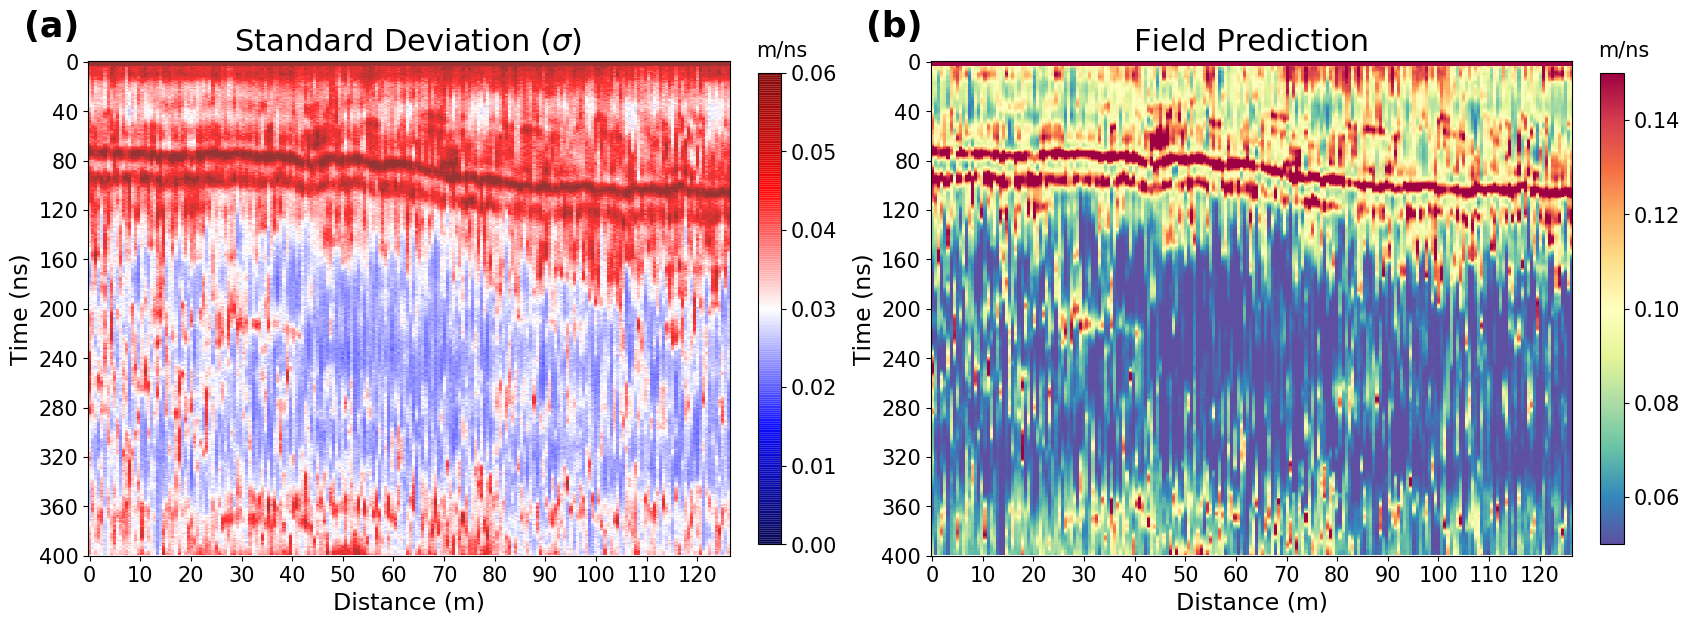

In [18]:
field_std_dev = []
for i in range(208):
    each_std = np.std(field_uncert['ind{}'.format(i)],axis=0)
    field_std_dev.append(each_std)
field_std_dev = np.array(field_std_dev)

matplotlib.rcdefaults()

def figure16():
    fig,axs =plt.subplots(1,2,figsize=(17,8))
    # fig.subplots_adjust(wspace=0.5)
    
    ft2m = 0.3048
    m2ft = 1/ft2m

    ax = axs[0]
    im = ax.imshow(field_std_dev.T,cmap='seismic',vmin=0, vmax=0.06,alpha=0.8)
    xticks = np.arange(0,208,10*m2ft/2) 
    ax.set_xticks(xticks)
    ax.set_xticklabels(np.arange(0,127,10),fontsize=15)
    ax.set_yticks(np.arange(0,420,40))
    ax.set_yticklabels(np.arange(0,420,40),fontsize=15)
    ax.set_xlabel('Distance (m)', fontsize=17)
    ax.set_ylabel('Time (ns)', fontsize=17)
    ax.set_aspect(aspect=0.4)
    cbar = fig.colorbar(im, ax=ax,fraction=0.034, pad=0.04)
    cbar.ax.tick_params(labelsize=15)
    cbar.ax.set_xlabel('m/ns',fontsize=15)
    cbar.ax.xaxis.set_label_coords(1,1.07)
    ax.set_title(r'Standard Deviation ($\sigma$) ',fontsize=22,pad=8)
    ax.text(-0.1, 1.05, '('+string.ascii_lowercase[0]+')', transform=ax.transAxes, size=25, weight='bold')

    ax2 = axs[1]
    im2 = ax2.imshow(FieldPrediction.T/1e9,cmap='Spectral_r',vmin=0.05,vmax=0.15)
    xticks = np.arange(0,208,10*m2ft/2) 
    ax2.set_xticks(xticks)
    ax2.set_xticklabels(np.arange(0,127,10),fontsize=15)
    ax2.set_yticks(np.arange(0,420,40))
    ax2.set_yticklabels(np.arange(0,420,40),fontsize=15)
    ax2.set_xlabel('Distance (m)', fontsize=17)
    ax2.set_ylabel('Time (ns)', fontsize=17)
    ax2.set_title('Prediction',fontsize=20)
    ax2.set_aspect(0.4)
    cbar2 = fig.colorbar(im2, ax=ax2,fraction=0.034, pad=0.04)
    cbar2.ax.tick_params(labelsize=15) 
    cbar2.ax.set_xlabel('m/ns',fontsize=15)
    cbar2.ax.xaxis.set_label_coords(1,1.07)
    ax2.set_title('Field Prediction',fontsize=22,pad=8)
    ax2.text(-0.1, 1.05, '('+string.ascii_lowercase[1]+')', transform=ax2.transAxes, size=25, weight='bold')

    fig.tight_layout()

figure16()